In [1]:
# Libraries
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pyspark.sql import SparkSession

In [2]:
# IMPORT 5 YEARS

# Collects parquet files 2020-2024
files = []
for year in range(2020, 2025):
    pattern = f"{year}/yellow_tripdata_{year}-*.parquet"
    files.extend(glob.glob(pattern))

files = sorted(files)

raw_df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_5905/2623190444.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  raw_df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)


In [4]:
raw_df.shape

(174689444, 20)

In [18]:
raw_df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
count,1.746894e+08,174689444,174689444,1.656319e+08,1.746894e+08,1.656319e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.746894e+08,1.656319e+08,6.654573e+07,7.108434e+07
mean,1.728645e+00,2022-09-22 16:17:49.536190,2022-09-22 16:42:52.623249,1.393533e+00,5.144675e+00,1.560160e+00,1.646723e+02,1.628431e+02,1.175979e+00,1.535402e+01,1.233199e+00,4.899775e-01,3.902375e+00,4.954341e-01,6.080711e-01,2.380470e+01,2.266526e+00,8.813634e-02,1.450622e-01
min,1.000000e+00,2001-01-01 00:03:14,1970-01-20 10:16:32,0.000000e+00,-3.062000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.333914e+08,-3.917000e+01,-5.500000e-01,-4.932200e+02,-1.406300e+02,-1.000000e+00,-2.567800e+03,-2.500000e+00,-1.250000e+00,-1.750000e+00
25%,1.000000e+00,2021-09-14 11:01:05.750000,2021-09-14 11:20:38.750000,1.000000e+00,1.050000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,7.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.308000e+01,2.500000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,2022-10-21 22:12:30,2022-10-21 22:29:38.500000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.140000e+01,5.000000e-01,5.000000e-01,2.250000e+00,0.000000e+00,3.000000e-01,1.776000e+01,2.500000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,2023-12-08 10:02:26,2023-12-08 10:20:16,1.000000e+00,3.350000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.850000e+01,2.500000e+00,5.000000e-01,3.660000e+00,0.000000e+00,1.000000e+00,2.604000e+01,2.500000e+00,0.000000e+00,0.000000e+00
max,7.000000e+00,2098-09-11 02:23:31,2098-09-11 02:52:04,1.120000e+02,3.986086e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,9.983100e+05,5.000008e+05,5.000005e+05,1.333914e+08,1.702880e+03,2.000000e+00,1.000004e+06,3.000000e+00,1.250000e+00,1.750000e+00
std,4.745320e-01,NaN,NaN,9.545513e-01,4.867041e+02,6.914025e+00,6.519929e+01,7.021261e+01,5.658858e-01,1.063931e+04,3.786966e+01,3.783017e+01,1.063832e+04,2.036597e+00,3.718933e-01,1.639487e+02,7.867797e-01,3.229388e-01,4.903220e-01


In [19]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174689444 entries, 0 to 174689443
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee       

# Fare EDA & Processing

In [20]:
df = raw_df

In [21]:
# Looking at possible outlier fares

print("Zero or negative fares:", (df["fare_amount"] < 3).sum())
print("Fares > $100:", (df["fare_amount"] > 100).sum())
print("Fares > $200:", (df["fare_amount"] > 200).sum())

Zero or negative fares: 2216730
Fares > $100: 363769
Fares > $200: 43340


## Standard City Rate, \$3 initial charge
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245
## Removing fares under 3 dollars because that is the minimum charge and removing outlier fares above 200 dollars.

In [23]:
# Removing outliers, keeping fares between $3-$200

df = df[(df["fare_amount"] >= 3) & (df["fare_amount"] <= 200)] # Minimum fare in yellow taxi is $3

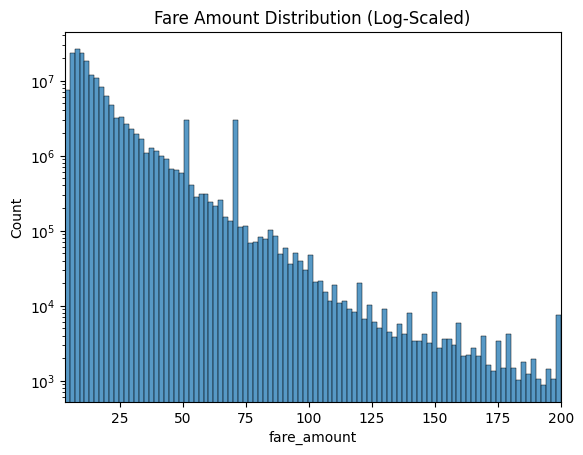

In [24]:
# Scatterplot to view fare distribution

sns.histplot(df["fare_amount"], bins=100)
plt.xlim(3, 200)  
plt.yscale("log")  # Log scale  to show more 
plt.title("Fare Amount Distribution (Log-Scaled)")
plt.show()


## Most of the spikes are around round numbers, with a big spike $70. 

## After some research, its very common to charge flat rates on standard trips like to the airport. Specifically to JFK is $70.

## John F. Kennedy Airport (JFK), To or from Manhattan (Rate Code 2), \$70 "Flat Fare."
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [30]:
# Calculate tip time and calculate fare per mile/minute
df["trip_time_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df["fare_per_min"] = df["fare_amount"] / df["trip_time_minutes"]
df["fare_per_mile"] = df["fare_amount"] / df["trip_distance"]

/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_5905/1574892531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["trip_time_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_5905/1574892531.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fare_per_min"] = df["fare_amount"] / df["trip_time_minutes"]
/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_5905/1574892531.py:4: Set

In [31]:
# Extract time based columns
df.loc[:, "hour"] = df["tpep_pickup_datetime"].dt.hour
df.loc[:, "dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek # 0 = Monday
df.loc[:, "month"] = df["tpep_pickup_datetime"].dt.month

/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_5905/2504261066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "hour"] = df["tpep_pickup_datetime"].dt.hour
/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_5905/2504261066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek # 0 = Monday
/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_5905/2504261066.py:4: SettingWithCopyWarning: 
A value is trying t

# Passenger EDA & Processing

## Maximum Number of Passengers - The maximum number of passengers allowed in a yellow taxicab by law is 4 in a 4-passenger taxicab or 5 in a 5-passenger taxicab.
#### https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [35]:
# Filter for 1-5 passengers. 4 or 5 is max allowed by taxi law in NYC
df.loc[:, "passenger_count"] = df["passenger_count"].clip(1, 5)

# Trip Distance EDA & Processing 

## Standard City Rate, 70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped.
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

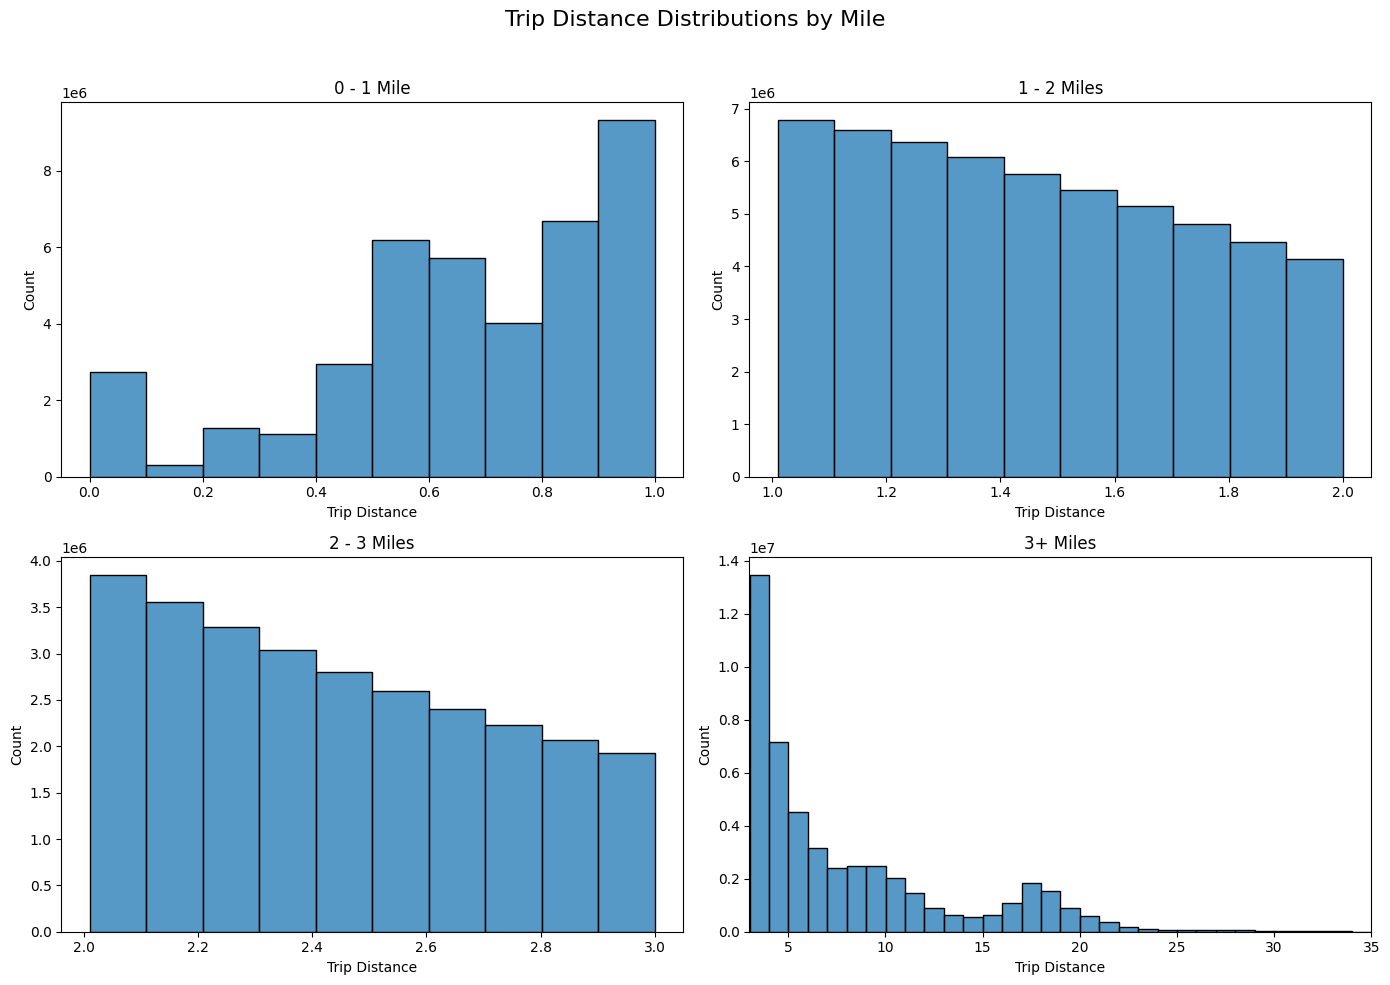

In [37]:
# Histogram of Trip Distance by Mile

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Trip Distance Distributions by Mile", fontsize=16)

# 0–1 mile
sns.histplot(df[(df["trip_distance"] >= 0) & (df["trip_distance"] <= 1)]["trip_distance"], bins=10, ax=axes[0, 0])
axes[0, 0].set_title("0 - 1 Mile")
axes[0, 0].set_xlabel("Trip Distance")
axes[0, 0].set_ylabel("Count")

# 1–2 miles
sns.histplot(df[(df["trip_distance"] > 1) & (df["trip_distance"] <= 2)]["trip_distance"], bins=10, ax=axes[0, 1])
axes[0, 1].set_title("1 - 2 Miles")
axes[0, 1].set_xlabel("Trip Distance")
axes[0, 1].set_ylabel("Count")

# 2–3 miles
sns.histplot(df[(df["trip_distance"] > 2) & (df["trip_distance"] <= 3)]["trip_distance"], bins=10, ax=axes[1, 0])
axes[1, 0].set_title("2 - 3 Miles")
axes[1, 0].set_xlabel("Trip Distance")
axes[1, 0].set_ylabel("Count")

# 3+ miles
sns.histplot(df[(df["trip_distance"] > 3) & (df["trip_distance"] <= 35)]["trip_distance"], bins=32, ax=axes[1, 1])
axes[1, 1].set_title("3+ Miles")
axes[1, 1].set_xlabel("Trip Distance")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_xlim(3, 35) 

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

In [38]:
# Filtering Trip Distance
df = df[(df["trip_distance"] >= 0) & (df["trip_distance"] <= 35)]

## Most trips are short distances. The standard rate (ratecode = 1) is for NYC county only. Filtering for trips >= 0 and <= 35 miles as the distance of NYC is approx 35 miles. "...the longest distance between its boundaries, from the northeast to the southwest, is about 35 miles."

#### source: https://www.takewalks.com/blog/nyc-by-the-numbers#:~:text=The%20total%20area%20of%20the,Staten%20Island%20and%20Long%20Island.

# RatecodeID EDA & Processing

In [39]:
metered_count = (df["RatecodeID"] == 1).sum()
total_count = len(df)

print(f"Metered fare rides (RatecodeID == 1): {metered_count:,}")
print(f"Percentage of rides (RatecodeID == 1): {metered_count / total_count:.2%}")

Metered fare rides (RatecodeID == 1): 155,656,072
Percentage of rides (RatecodeID == 1): 90.31%


## Looking at ratecode = 1, this is metered/standard rate rides. 91% of the rides are metered. Rates codes such as 2 and 3 are flat rates & negociated fares.

#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

### Below are the rate codes and their meaning. 
#### 1= Standard rate
#### 2=JFK
#### 3=Newark
#### 4=Nassau or Westchester
#### 5=Negotiated fare
#### 6=Group ride

In [40]:
# Filtering to RatecodeID == 1
df = df[df["RatecodeID"] == 1].copy() 

# Feature Engineering

In [43]:
# Correlation to fare amount

features = [
    "fare_amount",
    "trip_distance",
    "trip_time_minutes",
    "fare_per_min",
    "fare_per_mile",
    "passenger_count",
    "hour",
    "dayofweek",
    "month",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "congestion_surcharge",
    "tolls_amount",
    "tip_amount"]

corr = df[features].corr(numeric_only=True)
fare_corr = corr["fare_amount"].sort_values(ascending=False)

print(fare_corr)


fare_amount             1.000000
trip_distance           0.911981
tip_amount              0.550313
tolls_amount            0.464914
month                   0.049857
hour                    0.009812
fare_per_min            0.007477
passenger_count         0.002453
trip_time_minutes       0.001583
dayofweek              -0.001489
payment_type           -0.019107
fare_per_mile          -0.094333
PULocationID           -0.095411
DOLocationID           -0.105957
congestion_surcharge   -0.288362
Name: fare_amount, dtype: float64


### trip_distance, tip_amount and tolls_amount all have strong to moderate correlations to fare_amount. 
### Tip amount will not be used because tips are not known until the ride is over. Tip amount is discretionary, we are predicting the price of fare  for a customer's ride, not the fare plus tip. 
### Adding trip_in_minutes reduces rmse by more than half. This is likely because riders are also charged per minute. 
### "70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped"
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [46]:
# Filter extreme outliers for trip_time_minutes and tolls_amount

df = df[(df["trip_time_minutes"] >= 0) & (df["trip_time_minutes"] <= 1500) & 
    (df["tolls_amount"] >= 0) & (df["tolls_amount"] <= 100)]

In [48]:
percent_remaining = (len(df) / len(raw_df)) * 100

# Print results
print(f"Original row count: {len(raw_df)}")
print(f"Filtered row count: {len(df)}")
print("\n"f"Percentage of data retained: {percent_remaining:.2f}%")

Original row count: 174689444
Filtered row count: 155652442

Percentage of data retained: 89.10%


## We retained 89%% of the overall data after processing.

# Models

In [52]:
# Features and splitting 

features = [
    "trip_distance",
    "trip_time_minutes",
    "tolls_amount"]

X = df[features]
y = df["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [53]:
X_train.shape

(124521953, 3)

In [54]:
# Baseline Linear Model

L_model = LinearRegression()
L_model.fit(X_train, y_train)

y_pred = L_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 4.34
MAE: 2.96
R² Score: 0.8335


In [ ]:
# RF Model

rf_model = RandomForestRegressor(
    n_estimators=100,      
    max_depth=8,         
    n_jobs=-1,            
    random_state=2
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

In [55]:
# XGBoost Model

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

XGBoost RMSE: 2.77
MAE: 1.95
R² Score: 0.9323


In [82]:
# LightGB Model

lgb_model = LGBMRegressor(
    n_estimators=50,
    max_depth=8,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"R² Score: {r2_lgb:.4f}")

LightGBM RMSE: 2.74
MAE: 1.96
R² Score: 0.9336


## Light GBM has the most accuracy "out of the box."

# LGB Model Evaluation 

In [85]:
# 10 fold Cross Validation 
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
neg_rmse = cross_val_score(lgb_model, X, y, scoring=rmse_scorer, cv=10)

# Report results
print(f"Cross-validated RMSE scores: {-neg_rmse}")
print(f"Mean CV RMSE: {-neg_rmse.mean():.4f}")

Cross-validated RMSE scores: [2.32698114 2.32343429 2.69399805 2.71618725 3.00837918 3.05812671
 3.99334099 3.23218201 3.08693383 3.2176189 ]
Mean CV RMSE: 2.9657


### Model performs similarly on 10 fold cross validation. RMSE increased by about 20 cents, indicating the model is relatively robust. 

## Residuals LGB Model

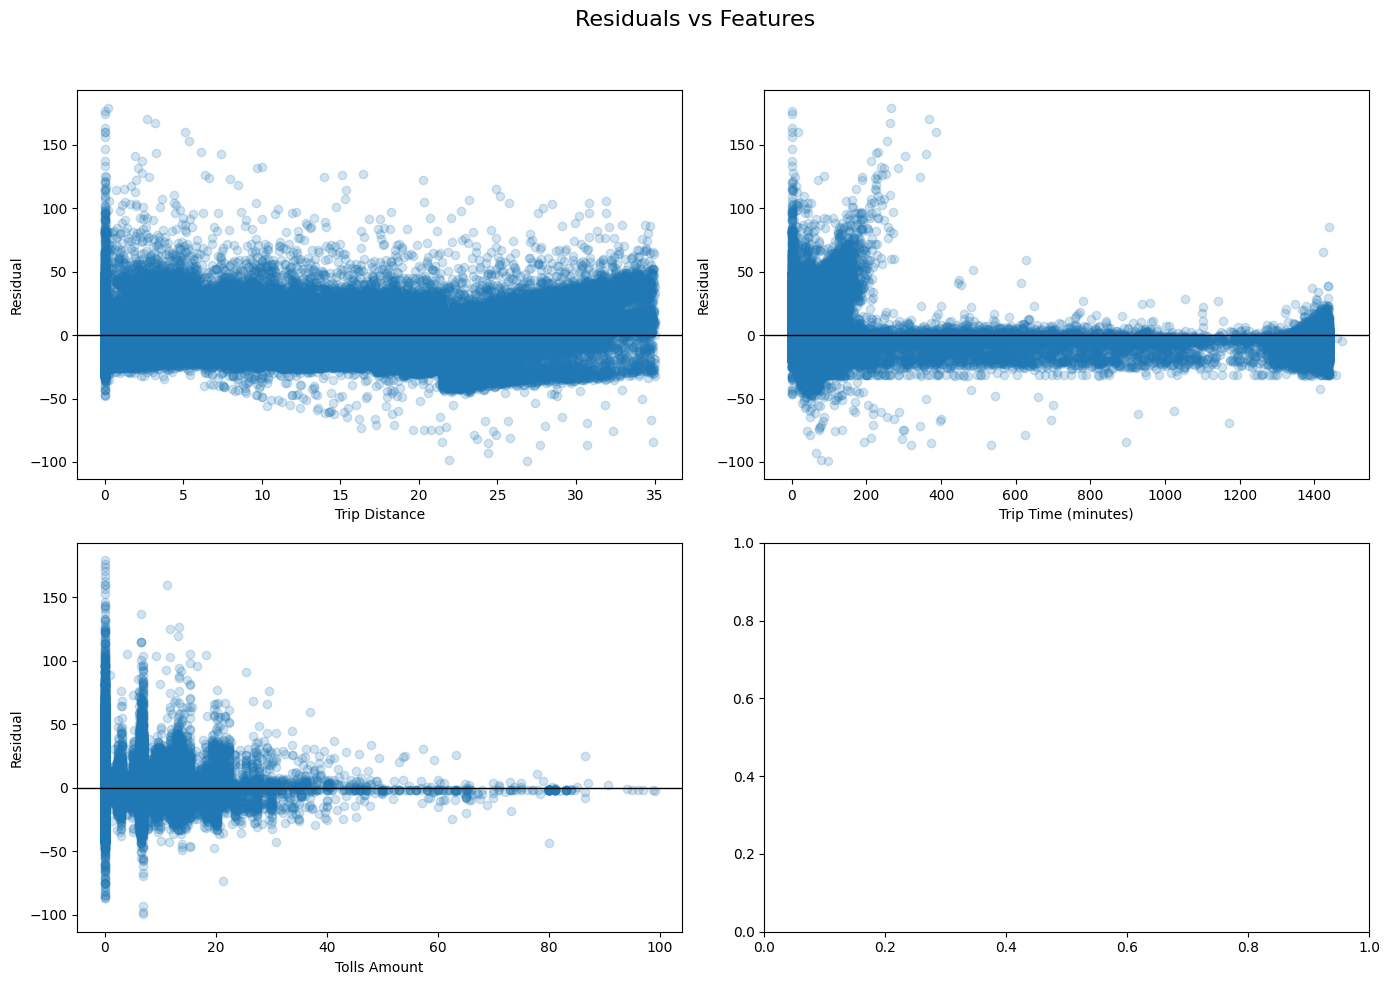

In [83]:
resid = y_test - y_pred_lgb

# 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Residuals vs Features", fontsize=16)

# trip_distance
axes[0, 0].scatter(X_test["trip_distance"], resid, alpha=0.2)
axes[0, 0].set_xlabel("Trip Distance")
axes[0, 0].set_ylabel("Residual")
axes[0, 0].axhline(0, color="black", linewidth=1)

# trip_time_minutes
axes[0, 1].scatter(X_test["trip_time_minutes"], resid, alpha=0.2)
axes[0, 1].set_xlabel("Trip Time (minutes)")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].axhline(0, color="black", linewidth=1)

# tolls_amount
axes[1, 0].scatter(X_test["tolls_amount"], resid, alpha=0.2)
axes[1, 0].set_xlabel("Tolls Amount")
axes[1, 0].set_ylabel("Residual")
axes[1, 0].axhline(0, color="black", linewidth=1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [84]:
print(f"Total training rows: {len(df)}")
print(f"Trips under 5 miles: {(df['trip_distance'] < 5).sum()}")
print(f"Percentage under 5 miles: {(df['trip_distance'] < 5).sum() / len(df) * 100:.2f}%")

Total training rows: 155652442
Trips under 5 miles: 136223949
Percentage under 5 miles: 87.52%


# UPADTE Evaluation ANALYSIS***

